In [1]:
import pandas as pd
import numpy as np
from time import ctime
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Datos de entrenamiento limpios y con features agregados
train = pd.read_csv('../data/to_train_01.csv', low_memory=False, lineterminator='\n')

print(train.info())
train.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 86 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   building_id                             260601 non-null  int64  
 1   damage_grade                            260601 non-null  int64  
 2   count_floors_pre_eq                     260601 non-null  int64  
 3   age                                     260601 non-null  int64  
 4   area_percentage                         260601 non-null  int64  
 5   height_percentage                       260601 non-null  int64  
 6   land_surface_condition                  260601 non-null  float64
 7   foundation_type                         260601 non-null  float64
 8   roof_type                               260601 non-null  float64
 9   ground_floor_type                       260601 non-null  float64
 10  other_floor_type                        2606

,building_id,damage_grade,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,...,altura_por_antiguedad,area_por_altura,producto_area_altura,area_al_cuadrado,altura_al_cuadrado,promedio_area_altura,cant_familias_por_pisos,cant_familias_por_area,cant_familias_por_altura,cant_materiales\r
0,802906,3,2,30,6,5,2.234176,2.329448,2.269586,2.309002,...,0.16129,1.2,30,36,25,5.5,0.5,0.166667,0.2,2


In [3]:
# Datos de prueba
test = pd.read_csv('../data/to_test_01.csv', low_memory=False, lineterminator='\n')
print(test.info())
test.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86868 entries, 0 to 86867
Data columns (total 85 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   building_id                             86868 non-null  int64  
 1   count_floors_pre_eq                     86868 non-null  int64  
 2   age                                     86868 non-null  int64  
 3   area_percentage                         86868 non-null  int64  
 4   height_percentage                       86868 non-null  int64  
 5   land_surface_condition                  86868 non-null  float64
 6   foundation_type                         86868 non-null  float64
 7   roof_type                               86868 non-null  float64
 8   ground_floor_type                       86868 non-null  float64
 9   other_floor_type                        86868 non-null  float64
 10  position                                86868 non-null  fl

,building_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,...,altura_por_antiguedad,area_por_altura,producto_area_altura,area_al_cuadrado,altura_al_cuadrado,promedio_area_altura,cant_familias_por_pisos,cant_familias_por_area,cant_familias_por_altura,cant_materiales\r
0,300051,3,20,7,6,2.234176,2.329448,2.269586,2.309002,2.315611,...,0.285714,1.166667,42,49,36,6.5,0.333333,0.142857,0.166667,1


## Entrenamiento del modelo

### Seleccion de features

In [4]:
def seleccion_de_features_to_remove(df_train):
    '''
    Funcion para seleccionar features.
    features_to_remove es la base que contiene building_id y damage_grade
    Las demas listas, las creamos y las agregamos a subset_features para luego appendearlas a features_to_remove
    '''
    features_to_remove = ['building_id', 'damage_grade']
    subset_features = []
    has_secondary = [col for col in df_train.columns if 'has_secondary' in col]
    legal_ownership = [col for col in df_train.columns if 'legal_ownership' in col]
    plan_configuration = [col for col in df_train.columns if 'plan_configuration' in col]
    probas = [col for col in df_train.columns if 'proba_danio' in col]
    relaciones_geo = [col for col in df_train.columns if 'relacion_' in col]
    cantidad_geo = [col for col in df_train.columns if 'cant_geolevel' in col]
    geo_level_embedded = [col for col in df_train.columns if 'geo_level_embedded_' in col]
    #subset_features.append(has_secondary)
    subset_features.append(cantidad_geo)
    subset_features.append(legal_ownership)
    subset_features.append(relaciones_geo)
    #subset_features.append(geo_level_embedded)
    subset_features.append(probas)
    #subset_features.append(plan_configuration)
    for subset in subset_features:
        features_to_remove += subset
    return features_to_remove

In [5]:
# Arreglo el nombre de la columna 'cant_materiales'
train.rename(columns={'cant_materiales\r': 'cant_materiales'}, inplace=True)
test.rename(columns={'cant_materiales\r': 'cant_materiales'}, inplace=True)

In [6]:
features_to_remove = seleccion_de_features_to_remove(train)
Y = train['damage_grade']
X = train.drop(features_to_remove, axis=1)

In [7]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1881, test_size=0.2)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 208480 entries, 5946 to 108188
Data columns (total 65 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   count_floors_pre_eq                     208480 non-null  int64  
 1   age                                     208480 non-null  int64  
 2   area_percentage                         208480 non-null  int64  
 3   height_percentage                       208480 non-null  int64  
 4   land_surface_condition                  208480 non-null  float64
 5   foundation_type                         208480 non-null  float64
 6   roof_type                               208480 non-null  float64
 7   ground_floor_type                       208480 non-null  float64
 8   other_floor_type                        208480 non-null  float64
 9   position                                208480 non-null  float64
 10  plan_configuration                      2

### Parameter tuning

> https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

In [9]:
import lightgbm as lgb
from sklearn.metrics import f1_score

# Buscamos la cantidad optima de estimadores para este learning_rate
y_train_restado = y_train - 1
y_test_restado = y_test - 1

best_params = {
    'objective' : 'multiclass',
    'num_class':3,
    'metric' : 'multi_error',
    'boosting': 'gbdt',
    'max_depth' : -1,
    'num_leaves' : 30,
    'learning_rate' : 0.05,
    'feature_fraction' : 0.5,
    'min_sum_hessian_in_leaf' : 0.1,
    'max_bin': 8192,
    'min_data_in_leaf':20,
    'verbosity' : 1,
    'num_threads':-1,
    'random_state':1881
}


train_data = lgb.Dataset(X_train, label=y_train_restado)
test_data = lgb.Dataset(X_test, label=y_test_restado)
# lgb.train devuelve la probabilidad para cada registro de pertenecer a cada uno de los distintos labels
lgb_clf = lgb.train(best_params, train_data, 20000, valid_sets=[test_data], early_stopping_rounds=3000, verbose_eval=1000)
y_pred = lgb_clf.predict(X_test)
print('Test Score: ', f1_score(y_pred.argmax(axis=1) + 1, y_test_restado + 1, average='micro'))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.223886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127871
[LightGBM] [Info] Number of data points in the train set: 208480, number of used features: 73
[LightGBM] [Info] Start training from score -2.333567
[LightGBM] [Info] Start training from score -0.564567
[LightGBM] [Info] Start training from score -1.095284
Training until validation scores don't improve for 3000 rounds
[1000]	valid_0's multi_error: 0.252988
[2000]	valid_0's multi_error: 0.241745
[3000]	valid_0's multi_error: 0.239002
[4000]	valid_0's multi_error: 0.237754
[5000]	valid_0's multi_error: 0.236834
[6000]	valid_0's multi_error: 0.236296
[7000]	valid_0's multi_error: 0.235874
[8000]	valid_0's multi_error: 0.235164
[9000]	valid_0's multi_error: 0.234704


KeyboardInterrupt: 

In [9]:
from sklearn.metrics import f1_score

#Training Score: 0.7925
#Test Score:  0.7513
#GridSearchCV score: 0.7462
#DD = 0.7473
#Los mejores parametros que dieron esto son los de best_params    

best_params = { 
    'boosting_type': 'gbdt',
    'feature_fraction': 0.6,
    'learning_rate': 0.1,
    'max_bin': 7000,
    'metric': 'multi_logloss',
    'min_data_in_leaf': 120,
    'min_sum_hessian_in_leaf': 0.1,
    'n_estimators': 530,
    'n_jobs': -1,
    'num_class': 3,
    'num_leaves': 40,
    'objective': 'multiclass',
    'random_state': 1881,
    'verbose': -1
}

param_search = {
    'learning_rate': [0.1],
    'objective':['multiclass'],
    'n_estimators':[530],
    'num_class':[3],
    'feature_fraction': [0.6],
    'num_leaves': [40],
    'metric':['multi_logloss'],
    'min_sum_hessian_in_leaf':[0.1],
    'random_state':[1881],
    'max_bin': [5000, 6000, 7000],
    'min_data_in_leaf':[100, 120, 170],
    'boosting_type' : ['gbdt'],
    'verbose':[-1],
    'n_jobs':[-1]
}

print('Hora antes de empezar a tunear/entrenar: {}'.format(ctime()))
model = GridSearchCV(estimator = LGBMClassifier(), param_grid=param_search, scoring='f1_micro', cv=4, n_jobs=-1, verbose=11)
model.fit(X_train, y_train)
print('Hora al finalizar de tunear/entrenar: {}'.format(ctime()))

# Vemos el score comprobando contra el set de test y de train
y_pred_test = model.predict(X_test)
model_f1_micro_test = f1_score(y_test, y_pred_test, average='micro')
y_pred_train = model.predict(X_train)
model_f1_micro_train = f1_score(y_train, y_pred_train, average='micro')
print('Training Score: %.4f' % model_f1_micro_train)
print('Test Score:  %.4f' % model_f1_micro_test)
print('GridSearchCV score: %.4f' % model.best_score_)
print('Mejor parametros hasta el momento: ')
model.best_params_

Hora antes de empezar a tunear/entrenar: Fri Jul 23 00:09:26 2021
Fitting 4 folds for each of 9 candidates, totalling 36 fits
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.1
Hora al finalizar de tunear/entrenar: Fri Jul 23 00:36:35 2021
Training Score: 0.7925
Test Score:  0.7513
GridSearchCV score: 0.7462
Mejor parametros hasta el momento: 


{'boosting_type': 'gbdt',
 'feature_fraction': 0.6,
 'learning_rate': 0.1,
 'max_bin': 7000,
 'metric': 'multi_logloss',
 'min_data_in_leaf': 120,
 'min_sum_hessian_in_leaf': 0.1,
 'n_estimators': 530,
 'n_jobs': -1,
 'num_class': 3,
 'num_leaves': 40,
 'objective': 'multiclass',
 'random_state': 1881,
 'verbose': -1}

### Feature importance

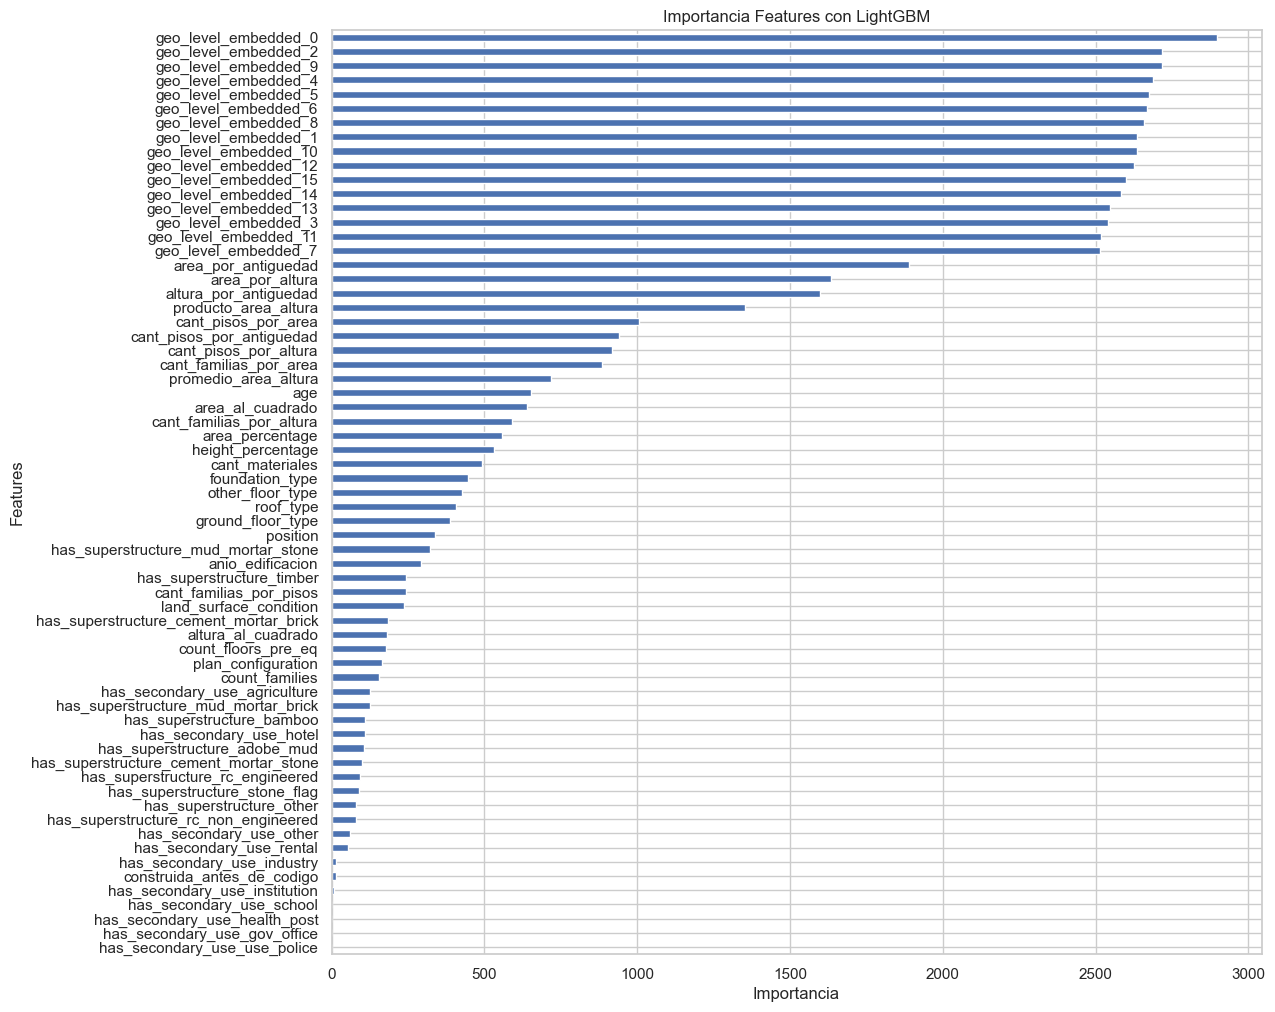

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('default')
sns.set(style='whitegrid') # seteando tipo de grid en seaborn

feature_cols = X.columns.tolist()
features = pd.Series(data=model.best_estimator_.feature_importances_, index=feature_cols, name='Feature importance')
features.sort_values(ascending=True, inplace=True)
plt.figure(figsize=(12, 12))
features.plot(kind='barh')
plt.xlabel('Importancia')
plt.ylabel('Features')
plt.title('Importancia Features con LightGBM')
plt.show()

La matriz de confusion nos muestra nuestros $tp$, $fp$, $tn$ y $fn$ en una matriz. La diagonal principal son los valores correctamente clasificados. Los otros valores indican la cantidad de puntos mal clasificados.
> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

In [11]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred):
    names = sorted(set(y_true))
    cm = confusion_matrix(y_true, y_pred, names)
    df_cm = pd.DataFrame(cm, names, names)

    plt.figure(dpi=100)
    plt.title('Matriz de confusion')
    sns.heatmap(df_cm, annot=True, annot_kws={'size': 16}, fmt='g', square=True)
    plt.ylabel('Label correcto')
    plt.xlabel('Label predecido')
    plt.show()

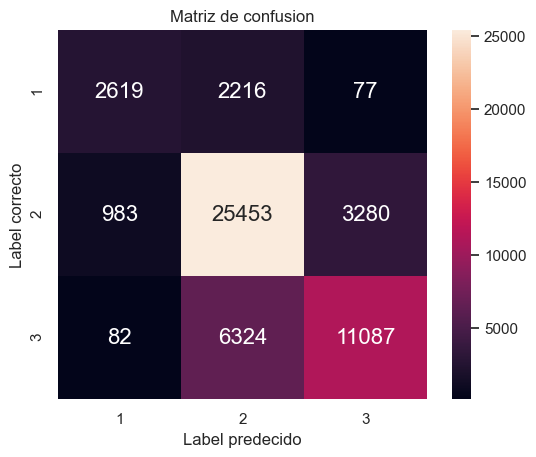

In [12]:
plot_confusion_matrix(y_test, y_pred_test)

### Prediccion del modelo

In [13]:
# Saco damage_grade de las features a remover ya que dicha feature NO esta en el set de test
features_to_remove.remove('damage_grade')
to_test = test.drop(features_to_remove, axis=1)

In [14]:
y_pred = model.predict(to_test)
y_pred

array([3, 2, 2, ..., 2, 2, 1], dtype=int64)

### Formateo de la prediccion para un submit

In [15]:
test_id = test['building_id']
test_id

0         300051
1          99355
2         890251
3         745817
4         421793
          ...   
86863     310028
86864     663567
86865    1049160
86866     442785
86867     501372
Name: building_id, Length: 86868, dtype: int64

In [16]:
submit = pd.concat([test_id, pd.Series(y_pred, name='damage_grade')], axis=1)
submit.set_index('building_id', inplace=True)
submit.head()

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,3


In [17]:
submit.to_csv('../submits-csv/submit-LightGBM-{}.csv'.format(model_f1_micro_test))